# Assignment 2

**Due to**: 23/12/2021 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## 2.1 Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

```
{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}
```

---

**Not Verifiable**

```
{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}
```

---

## 2.2 Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build `(claim, evidence)` pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

[**Note**]: The dataset requires some text cleaning as you may have noticed!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## 4.1 Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## 5.1 Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: `[batch_size, max_tokens]`
*    Evidence: `[batch_size, max_tokens]`

Moreover, after the embedding layer, we'll have:

*    Claim: `[batch_size, max_tokens, embedding_dim]`
*    Evidence: `[batch_size, max_tokens, embedding_dim]`

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: `[batch_size, dim]`

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

1.   Encode token sequences via a RNN and take the last state as the sentence embedding.

2.  Encode token sequences via a RNN and average all the output states.

3.  Encode token sequences via a simple MLP layer. In particular, if your input is a `[batch_size, max_tokens, embedding_dim]` tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a `[batch_size, embedding_dim]` 2D matrix. Alternatively, you can reshape the 3D input tensor from `[batch_size, max_tokens, embedding_dim]` to `[batch_size, max_tokens * embedding_dim]` and then apply the MLP layer.

4.   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## 5.2 Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if the sentence embedding of a single input has shape `[batch_size, embedding_dim]`, then the classification input has shape:

*     **Concatenation**: `[batch_size, 2 * embedding_dim]`

*     **Sum**: `[batch_size, embedding_dim]`

*     **Mean**: `[batch_size, embedding_dim]`

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: `[batch_size, 2 * embedding_dim + 1]`

*     **Sum**: `[batch_size, embedding_dim + 1]`

*     **Mean**: `[batch_size, embedding_dim + 1]`



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

---

A. **Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

---

B. **Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

---

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

Shortly speaking, implement both strategies for your classification metrics.

# Tips and Extras

## 8.1 Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

**Don't forget to try neural baselines first!**

## 8.2 Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## 8.3 Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Evaluation

Which are the evaluation criteria on which we'll judge you and your work?

1. Pre-processing: whether you have done some pre-processing or not.
2. Sentence embedding: you should implement all required strategies (with an example and working code for each). That is, we, as evaluators, should be able to test all strategies without writing down new code.
3. Multiple inputs merging strategies: you should implement all required strategies (with an example and working code for each).
4. Similarity extension: you should implement the cosine similarity extension (with an example and working code).
5. Voting strategy: you should implement the majority voting strategy and provide results.
6. Report: when submitting your notebook, you should also attach a small summary report that describes what you have done (provide motivations as well for abitrary steps. For instance, "We've applied L2 regularization since the model was overfitting".

Extras (possible extra points):

1. Any well defined extension is welcome!
2. Well organized and commented code is as important as any other criteria.

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

*Note*: We highly recommend you to check the [course useful material](https://virtuale.unibo.it/pluginfile.php/1036039/mod_resource/content/2/NLP_Course_Useful_Material.pdf) for additional information before contacting us!

# FAQ

---

**Question**: Can I do something text pre-processing?

**Answer:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Question**: The model architecture schema is not so clear, are we doing end-to-end training?

**Answer**: Exactly! All models can be thought as:

1. Input
2. (word) Embedding
3. Sentence embedding
4. Multiple inputs merging
5. Classification

---

**Question**: Can I extend models by adding more layers?

**Answer**: Feel free to define model architectures as you wish, but remember satisfy our requirements. This assignment should not be thought as a competition to achieve the best performing model: fancy students that want to show off but miss required assignment objectives will be punished!!

---

**Question**: I'm struggling with the implementation. Can you help me?

**Answer**: Yes sure! Contact us and describe your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Question**: Can I try other encoding strategies or neural architectures?

**Answer:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---

**Question**: Do we have to test all possible sentence embedding and input merging combinations?

**Answer**: Absolutely no! Feel free to pick one sentence embedding strategy and try all possible input merging strategies with it! For instance, pick the best performing sentence embedding method and proceed with next steps (extras included). Please, note that you still have to implement all mentioned strategies!

---

**Question**: I'm hitting out of memory error when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length
3. Check the efficiency of your custom code implementation (if any)
4. Try to define same length mini-batches to avoid padding (**It should not be necessary here!**)

---

**Question**: I'm hitting CUDNN_STATUS_BAD_PARAM error! What I'm doing wrong?

**Answer**: This error is a little bit tricky since the stack trace is not meaningful at all! This error occurs when the RNN is fed with a sequence of all 0s and pad masking is enabled (e.g. from the embedding layer). Please, check your conversion step, since there might be an error that leads to the encoding of a sentence to all 0s.

---

##Import Libraries

In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.41 s (started: 2021-12-27 19:15:53 +00:00)


In [ ]:
import os
import re
import math
import nltk
import string
import random
import gensim
import zipfile
import sklearn
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from itertools import chain
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from collections import namedtuple
import gensim.downloader as gloader
from collections import OrderedDict, Counter
from tensorflow.python.ops.numpy_ops import np_config  
from tensorflow.keras.models import Model
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer
np_config.enable_numpy_behavior()
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score,precision_score,recall_score
from tensorflow.keras.layers import (Input, LayerNormalization, LSTM, Dense,  Bidirectional, Embedding, concatenate, Add, Average, Flatten, Dropout)

time: 18.2 ms (started: 2021-12-27 19:15:58 +00:00)


In [ ]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

time: 21.6 ms (started: 2021-12-27 19:15:58 +00:00)


Reading Data from the extracted .csv files


In [ ]:
folder = os.path.join(os.getcwd(), "dataset")
df_train = pd.read_csv(folder + '/'+ 'train_pairs.csv', index_col = [0])
df_test = pd.read_csv(folder + '/' +  'test_pairs.csv', index_col = [0])
df_val = pd.read_csv(folder + '/' + 'val_pairs.csv', index_col = [0])


time: 963 ms (started: 2021-12-27 19:15:58 +00:00)


In [ ]:
(df_train.shape[0])+(df_test.shape[0])+(df_val.shape[0])

136094

time: 9.18 ms (started: 2021-12-27 19:15:59 +00:00)


##Shapes of the dataset

In [ ]:
#reduction OF DATASET BY 90% SO PREPROCESSING IS EASIER

# df_train = df_train.head(int(len(df_train)*.1))
# df_test = df_test.head(int(len(df_test)*.1))
# df_val = df_val.head(int(len(df_val)*.1))

time: 1.53 ms (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
print('Train shape :' ,df_train.shape)
print('Test shape :' ,df_test.shape)
print('Val shape :' ,df_val.shape)

list_train_val_test = [df_train, df_val, df_test]

Train shape : (121740, 4)
Test shape : (7189, 4)
Val shape : (7165, 4)
time: 10.7 ms (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
df_train.head()

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


time: 52.3 ms (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
df_train['Label'].unique()

array(['SUPPORTS', 'REFUTES'], dtype=object)

time: 31.4 ms (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
df_val.head()

,Claim,Evidence,ID,Label
0,The Indian Army comprises part of the country'...,16\tIt is an all-volunteer force and comprises...,98304,SUPPORTS
1,Recovery features Rihanna.,6\tEminem also collaborated with artists such ...,98305,SUPPORTS
2,Rihanna is on Recovery.,6\tEminem also collaborated with artists such ...,98306,SUPPORTS
3,Philomena was nominated.,8\tThe film was nominated in four categories a...,27307,SUPPORTS
4,Vietnam is a mascot.,0\tVietnam -LRB- ˌ ; -LSB- vîət nāːm -RSB- -RR...,98312,REFUTES


time: 23.9 ms (started: 2021-12-27 19:15:59 +00:00)


##Distribution of the datasets

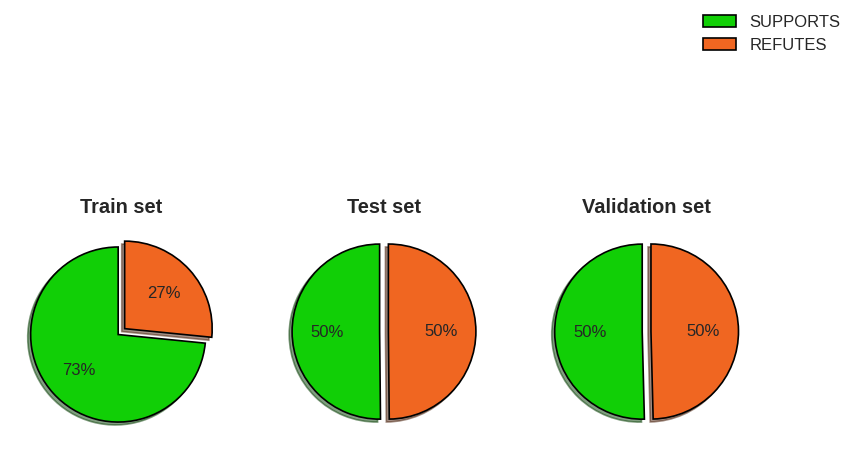

time: 421 ms (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
plt.style.use('seaborn')
TRNLBL = df_train['Label'].value_counts().to_frame().T
TSTLBL = df_test['Label'].value_counts().to_frame().T
VALLBL = df_val['Label'].value_counts().to_frame().T
total = pd.concat([TRNLBL, TSTLBL, VALLBL])
fig, ax = plt.subplots(nrows=1, ncols=3, dpi = 120)

labels = 'SUPPORTS', 'REFUTES'
colors = ['#11CF06', '#F06621']
explode = (0.05, 0.05)

plt.title('Pie chart for Labels in Train Test and Validation set')
#plt.tight_layout()
ax[0].pie(total.iloc[0], startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':1}, explode=explode, autopct='%1.f%%', shadow=True)
ax[0].set_title('Train set', fontweight='bold')
ax[1].pie(total.iloc[1],  startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':1}, autopct='%1.f%%', explode=explode, shadow=True)
ax[1].set_title('Test set', fontweight='bold')
ax[2].pie(total.iloc[2],  startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth':1}, autopct='%1.f%%', explode=explode, shadow=True)
ax[2].set_title('Validation set', fontweight='bold')
#fig.set_figheight(4)
#fig.set_figwidth(10)
fig.legend(labels=labels, fontsize='medium')

fig.savefig('Label distribution in dataframes')

plt.show()

In [ ]:
df_train['Evidence']

0         2\tHemsworth has also appeared in the science ...
1         0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
2         0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
3         10\tThe island 's geography comprises relative...
4         10\tThe island 's geography comprises relative...
                                ...                        
121735    0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...
121736    0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...
121737    0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...
121738    0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...
121739    0\tAnderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiw...
Name: Evidence, Length: 121740, dtype: object

time: 6.49 ms (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
#Here we save claim and evidence corpus before the preprocessing step
corpus_evidence_before = df_train['Evidence'].astype(str).str.lower().str.split()
corpus_claim_before = df_train['Claim'].astype(str).str.lower().str.split()

time: 3.08 s (started: 2021-12-27 19:15:59 +00:00)


In [ ]:
corpus_claim_before

0         [chris, hemsworth, appeared, in, a, perfect, g...
1                             [roald, dahl, is, a, writer.]
2                           [roald, dahl, is, a, governor.]
3         [ireland, has, relatively, low-lying, mountains.]
4         [ireland, does, not, have, relatively, low-lyi...
                                ...                        
121735    [april, was, the, month, anderson, silva, was,...
121736    [anderson, silva, is, an, american, brazilian,...
121737    [anderson, silva, is, incapable, of, being, a,...
121738    [anderson, silva, was, born, on, the, month, o...
121739    [anderson, silva, was, born, on, the, day, of,...
Name: Claim, Length: 121740, dtype: object

time: 26.7 ms (started: 2021-12-27 19:16:02 +00:00)


# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build `(claim, evidence)` pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

[**Note**]: The dataset requires some text cleaning as you may have noticed!


#Preprocessing

In [ ]:
TAB_CHAR = "\t"
PERIOD_CHAR = "."
LEFT_PARENS = "-LRB-"
RIGHT_PARENS = "-RRB-"
SQUARE_BRACKETS = r"-LSB-.*-RSB-"

# We can change the stemming by using differnet name, here we used lancaster method. 
def stemming_process(text, stem= 'lancaster'):
  if stem not in ['porter','lancaster','snowball']:
    print("Expected values are: porter','lancaster','snowball.")
  if stem == 'porter':
    st = PorterStemmer() 
  if stem == 'lancaster':  
    st = LancasterStemmer()
  if stem == 'snowball':
    st = SnowballStemmer("english")
  return ''.join([st.stem(w) for w in text])

# Preprocessing for the claims
def preprocess_claim(text):
    """
    Pre-processing step for claims
    """
    # Remove the last punctuation symbol
    if text[-1] in string.punctuation:
        text = text[:-1]

    # text = stemming_process(text)

    # Strip whitespaces and convert to lowercase
    return text.strip().lower()

# Preprocessing for the evidences
def preprocess_evidence(text):
    # Preprocessing for first tab character
    text = text[text.find(TAB_CHAR) + len(TAB_CHAR) :]
    # Preprocessing for spaces
    text = text.replace(TAB_CHAR, " ")
    # Preprocessing for parenthesis
    text = text.replace(LEFT_PARENS, " ").replace(RIGHT_PARENS, " ")
    # Preprocessing for square brackets
    text = re.sub(SQUARE_BRACKETS, "", text)
    # Preprocessing for last period
    last_period = text.rfind(PERIOD_CHAR)
    if last_period is not None:
        text = text[:last_period]
    # Preprocessing for punctuation
    text = text.translate(text.maketrans("", "", string.punctuation))
    # Preprocessing for whitespaces
    text = " ".join(text.split())
    
    # stemming operation
    # text = stemming_process(text)
 
    # Preprocessing for lowercase
    return text.lower()
    
    

time: 186 ms (started: 2021-12-27 19:16:02 +00:00)


In [ ]:
#testing the preprocssing for a random index
random_index = random.choice(df_train.index.tolist())
print("The random index is: ", random_index)

c = df_train.loc[random_index]["Claim"]
print("The claim: ", c)

preprocessed_c = preprocess_claim(c)
print("The preprocessed claim: ", preprocessed_c)

e = df_train.loc[random_index]["Evidence"]
print("The evidence: ", e)

preprocessed_e = preprocess_evidence(e)
print("The preprocessed evidence is: ", preprocessed_e)

The random index is:  114132
The claim:  Ray Milland worked with a studio.
The preprocessed claim:  ray milland worked with a studio
The evidence:  8	This led to a nine-month contract with MGM and he moved to the United States where he appeared as a stock actor .	MGM	Metro-Goldwyn-Mayer
The preprocessed evidence is:  this led to a ninemonth contract with mgm and he moved to the united states where he appeared as a stock actor
time: 48.3 ms (started: 2021-12-27 19:16:03 +00:00)


In [ ]:
def convert_toBinary(df):
    df['Label'].loc[(df['Label'] == 'SUPPORTS')] = 1
    df['Label'].loc[(df['Label'] == 'REFUTES')] = 0

for df in list_train_val_test:
    convert_toBinary(df)

time: 104 ms (started: 2021-12-27 19:16:03 +00:00)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_train["Claim"] = df_train["Claim"].map(lambda s: preprocess_claim(s).split())
df_train["Evidence"] = df_train["Evidence"].map(lambda s: preprocess_evidence(s).split()[1:])

df_val["Claim"] = df_val["Claim"].map(lambda s: preprocess_claim(s).split())
df_val["Evidence"] = df_val["Evidence"].map(lambda s: preprocess_evidence(s).split()[1:])

df_test["Claim"] = df_test["Claim"].map(lambda s: preprocess_claim(s).split())
df_test["Evidence"] = df_test["Evidence"].map(lambda s: preprocess_evidence(s).split()[1:])

time: 2.77 s (started: 2021-12-27 19:16:03 +00:00)


In [ ]:
df_train.head()

,Claim,Evidence,ID,Label
0,"[chris, hemsworth, appeared, in, a, perfect, g...","[has, also, appeared, in, the, science, fictio...",3,1
1,"[roald, dahl, is, a, writer]","[dahl, 13, september, 1916, 23, november, 1990...",7,1
2,"[roald, dahl, is, a, governor]","[dahl, 13, september, 1916, 23, november, 1990...",8,0
3,"[ireland, has, relatively, low-lying, mountains]","[island, s, geography, comprises, relatively, ...",9,1
4,"[ireland, does, not, have, relatively, low-lyi...","[island, s, geography, comprises, relatively, ...",10,0


time: 32.4 ms (started: 2021-12-27 19:16:06 +00:00)


##Analysis of Data before and after the preprocessing step


\Let's do analysis of the preprocessing...
The reduction of tokens in the Evidence was of 14.20 %


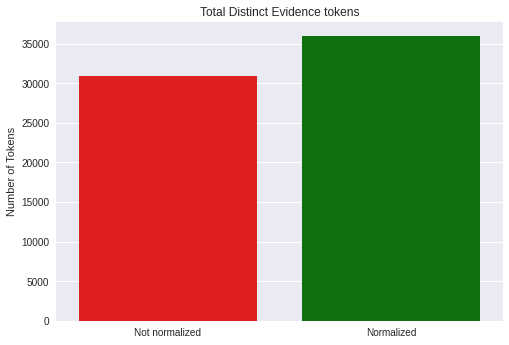

The reduction of tokens in the Claim was of 25.51 %


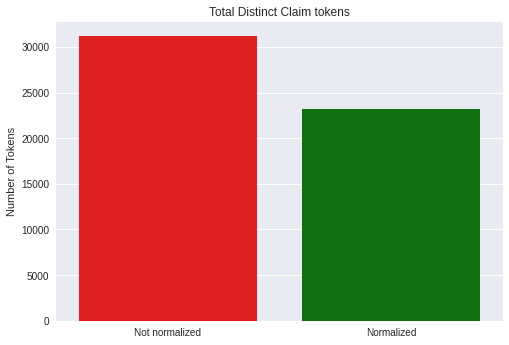

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


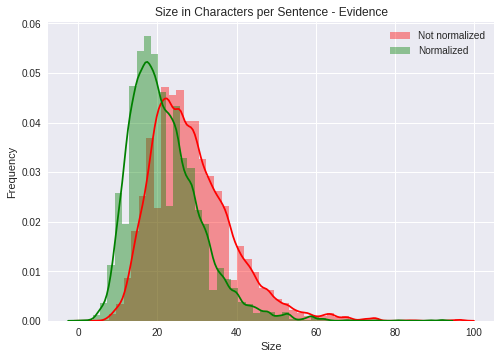

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


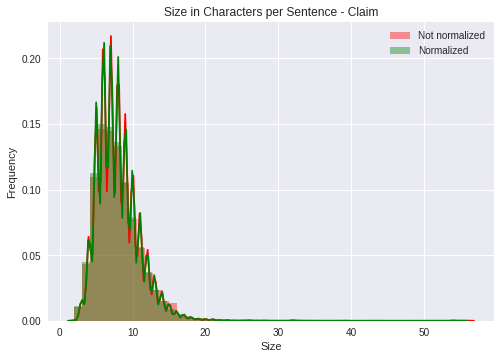

========BEFORE PREPROCESSING========
The vocabulary of evidence had: 35964 tokens
The vocabulary of claim had: 31185 tokens
The largest sample in the evidence had: 97 tokens
The largest sample in the claim had: 56 tokens

========AFTER PREPROCESSING========
The vocabulary of evidence has: 30856 tokens, was reduced in 14.20 %
The vocabulary of claim has: 23229 tokens , was reduced in 25.51 %
The largest sample in the evidence has: 92 tokens
The largest sample in the claim has: 55 tokens
time: 15.8 s (started: 2021-12-27 19:16:06 +00:00)


In [ ]:
'''
Analysis of Data before and after the preprocessing step
'''
def get_voc_from_corpus(corpus):
  vocabulary = set([elem for seq in corpus for elem in seq])
  return vocabulary

def get_unique_tokens_from_text(text):
  return set([x for x in text])

# Before preprocessing
evidence_before = get_voc_from_corpus(corpus_evidence_before)
claim_before = get_voc_from_corpus(corpus_claim_before)

evidence_sentence_before = [len(get_unique_tokens_from_text(x)) for x in corpus_evidence_before]
claim_sentence_before = [len(get_unique_tokens_from_text(x)) for x in corpus_claim_before]
#After
evidence_after = get_voc_from_corpus(df_train['Evidence'])
claim_after = get_voc_from_corpus(df_train['Claim'])

evidence_sentence_after = [len(get_unique_tokens_from_text(x)) for x in df_train['Evidence']]
claim_sentence_after = [len(get_unique_tokens_from_text(x)) for x in df_train['Claim']]


print("==================================================")
print("\n\Let's do analysis of the preprocessing...")
#Total Number of Distinct Tokens for the Evidence
evid_reduction = 100* (len(evidence_before) - len(evidence_after) )/ len(evidence_before) 
print("The reduction of tokens in the Evidence was of {:.2f} %".format(evid_reduction))
sns.barplot(x=["Not normalized","Normalized"],y=[len(evidence_after), len(evidence_before)], palette=['red', 'green'])
plt.title('Total Distinct Evidence tokens')
plt.ylabel('Number of Tokens')
plt.show();
#Total Number of Distinct Tokens for the Claim
claim_reduction = 100* (len(claim_before) - len(claim_after) )/ len(claim_before)
print("The reduction of tokens in the Claim was of {:.2f} %".format(claim_reduction))
sns.barplot(x=["Not normalized","Normalized"],y=[len(claim_before), len(claim_after)], palette=['red', 'green'])
plt.title('Total Distinct Claim tokens')
plt.ylabel('Number of Tokens')
plt.show();

#Size of sentences for the Evidence
sns.distplot(evidence_sentence_before, label='Not normalized', color='r')
sns.distplot(evidence_sentence_after, label='Normalized', color='g')
plt.legend(loc='upper right')
plt.title('Size in Characters per Sentence - Evidence')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show();
#Size of sentences for the Claim
sns.distplot(claim_sentence_before, label='Not normalized', color='r')
sns.distplot(claim_sentence_after, label='Normalized', color='g')
plt.legend(loc='upper right')
plt.title('Size in Characters per Sentence - Claim')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show();
print("========BEFORE PREPROCESSING========")
print("The vocabulary of evidence had: {} tokens".format(len(evidence_before)))
print("The vocabulary of claim had: {} tokens".format(len(claim_before)))
print("The largest sample in the evidence had: {} tokens".format(max(evidence_sentence_before)))
print("The largest sample in the claim had: {} tokens".format(max(claim_sentence_before)))
print("\n========AFTER PREPROCESSING========")
print("The vocabulary of evidence has: {} tokens, was reduced in {:.2f} %".format(len(evidence_after), evid_reduction))
print("The vocabulary of claim has: {} tokens , was reduced in {:.2f} %".format(len(claim_after), claim_reduction))
print("The largest sample in the evidence has: {} tokens".format(max(evidence_sentence_after)))
print("The largest sample in the claim has: {} tokens".format(max(claim_sentence_after)))



##Data Visualization

WordCloud of Supported Claims


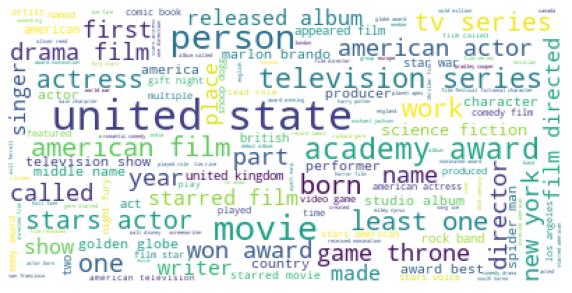

time: 28 s (started: 2021-12-27 19:16:22 +00:00)


In [ ]:
from wordcloud import WordCloud

def return_sentences(tokens):
    return " ".join([word for word in tokens])

txt_claim_sup = " ".join([x for x in df_train[df_train['Label'] == 1].Claim.apply(lambda x : return_sentences(x)) ])
txt_evidence_sup = " ".join([x for x in df_train[df_train['Label'] == 1].Evidence.apply(lambda x : return_sentences(x)) ])

wordcloud_claim_sup = WordCloud(max_font_size=30, max_words=1000, background_color = 'white').generate(txt_claim_sup)
wordcloud_evidence_sup = WordCloud(max_font_size=30, max_words=1000, background_color = 'white').generate(txt_evidence_sup)

# Display the generated image:
print("WordCloud of Supported Claims")
plt.figure(figsize= [10,10])
plt.imshow(wordcloud_claim_sup)
plt.axis("off")
plt.show();


WordCloud of Refuted Claims


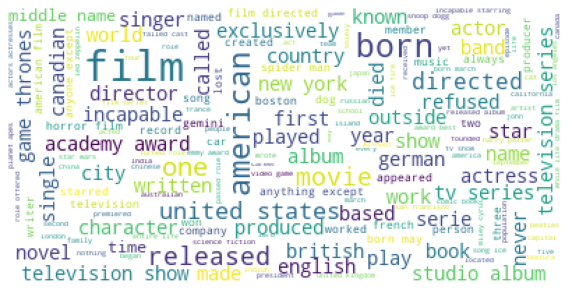

time: 9.68 s (started: 2021-12-27 19:16:50 +00:00)


In [ ]:

txt_claim_ref = " ".join([x for x in df_train[df_train['Label'] == 0].Claim.apply(lambda x : return_sentences(x)) ])
txt_evidence_ref = " ".join([x for x in df_train[df_train['Label'] == 0].Evidence.apply(lambda x : return_sentences(x)) ])

wordcloud_claim_ref = WordCloud(max_font_size=30, max_words=1000, background_color = 'white').generate(txt_claim_ref)
wordcloud_evidence_ref = WordCloud(max_font_size=30, max_words=1000, background_color = 'white').generate(txt_evidence_ref)

# Display the generated image:
print("WordCloud of Refuted Claims")
plt.figure(figsize= [10,10])
plt.imshow(wordcloud_claim_ref)
plt.axis("off")
plt.show();


###Utils functions for embedding

In [ ]:
def percentage(value,TrueValue):
  return int((value/TrueValue)*100)

time: 1.85 ms (started: 2021-12-27 19:16:59 +00:00)


###Glove embedding

In [ ]:
def load_embedding_model(embedding_model_type,embedding_dimension):
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_model 

embedding_dimension = 100 
print("Glove embedding:", embedding_dimension)
embedding_model = load_embedding_model('glove',embedding_dimension) 

Glove embedding: 100
[==================================================] 100.0% 128.1/128.1MB downloaded
time: 1min 51s (started: 2021-12-27 18:59:41 +00:00)


###Building vocabulary

In [ ]:
def build_Vocabulary(words, special_tokens=[]):
    wordset = set()
    wordset = wordset.union(*[set([word for word in wordlist]) for wordlist in words])
    word_to_index, index_to_word = OrderedDict(),OrderedDict()
    for i,w in enumerate(chain(special_tokens, wordset)):
        word_to_index[w],index_to_word[i]= i,w 
    return word_to_index, index_to_word

time: 5.94 ms (started: 2021-12-27 19:01:33 +00:00)


###Building vocabulary for Training data

In [ ]:
padding, unknown, = '<pad>', '<unk>'
word_to_index_train, _ = build_Vocabulary(df_train["Claim"].append(df_train["Evidence"], [padding, unknown]))
print(len(word_to_index_train),"\n",(word_to_index_train))

39064 
 OrderedDict([('sixepisode', 0), ('cryptid', 1), ('homogeneous', 2), ('harvard', 3), ('philosophical', 4), ('1808', 5), ('engineered', 6), ("ramis'", 7), ('backstroke', 8), ('sunburn', 9), ('reichstag', 10), ('diddy', 11), ('franks', 12), ('kaui', 13), ('see', 14), ('dysphonia', 15), ('downey', 16), ('governorate', 17), ('maire-claude', 18), ('featuring', 19), ('reisz', 20), ('fairuza', 21), ('veeru', 22), ('coccus', 23), ('canton,', 24), ('henchy', 25), ('zambia', 26), ('server', 27), ('shalini', 28), ('benzos', 29), ('positively', 30), ('on-set', 31), ('mézières', 32), ('campaign', 33), ('prominent', 34), ('names:', 35), ('coastline', 36), ('ioc', 37), ('highestgrossing', 38), ('middleearth', 39), ('gondorff', 40), ('catecholamine', 41), ('thennickname', 42), ('does', 43), ('matt', 44), ('releasing', 45), ('abundant', 46), ("dragons'", 47), ('1987),', 48), ('(2007),', 49), ('clay,', 50), ('rumble,', 51), ('viscount', 52), ('15th-century', 53), ('thora', 54), ('textbooks', 55),

###Building vocabulary for Validation data

In [ ]:
padding,unknown, = '<pad>', '<unk>'
word_to_index_val, _ = build_Vocabulary(df_val["Claim"].append(df_val["Evidence"], [padding, unknown]))
print(len(word_to_index_val),"\n",word_to_index_val,"\n")

9366 
 OrderedDict([('sixepisode', 0), ('prominence', 1), ('faddey', 2), ('mouth', 3), ('robinson', 4), ('ghibli', 5), ('service', 6), ('harvard', 7), ('lemke', 8), ('christa', 9), ('high-grossing', 10), ('guam', 11), ('guide', 12), ('hialeah', 13), ('400', 14), ('franks', 15), ('see', 16), ('resting', 17), ('landon', 18), ('downey', 19), ('featuring', 20), ('independently', 21), ('veeru', 22), ('ballroom', 23), ('itself', 24), ('girl', 25), ('ferret', 26), ('vick', 27), ('conception', 28), ('positively', 29), ('lady', 30), ('(poem)', 31), ('prominent', 32), ('highestgrossing', 33), ('neefe', 34), ('20gun', 35), ('monumental', 36), ('commonwealth', 37), ('opening', 38), ('does', 39), ('matt', 40), ('revenue', 41), ('releasing', 42), ('marykate', 43), ('el', 44), ('stood', 45), ('cook', 46), ('individuals', 47), ('canadians', 48), ('organizations', 49), ('competitions', 50), ('multi-toed', 51), ('re', 52), ('dempster', 53), ('wizards', 54), ('cc', 55), ('manoj', 56), ('traction', 57), (

###Building vocabulary for Testing data

In [ ]:
word_to_index_test, _ = build_Vocabulary(df_test["Claim"].append(df_test["Evidence"], [padding, unknown]))
print(len(word_to_index_test),"\n",word_to_index_test)

10497 
 OrderedDict([('disestablished', 0), ('homogeneous', 1), ('kassell', 2), ('service', 3), ('1808', 4), ('philosophical', 5), ('sunburn', 6), ('see', 7), ('featuring', 8), ('considerably', 9), ('independently', 10), ('pled', 11), ('dying', 12), ('girl', 13), ('server', 14), ('quay', 15), ('benzos', 16), ('campaign', 17), ('prominent', 18), ('highestgrossing', 19), ('does', 20), ('matt', 21), ('releasing', 22), ('viscount', 23), ('ministerstvo', 24), ('termed', 25), ('multnomah', 26), ('individuals', 27), ('middlesex', 28), ("`prestigious'", 29), ('cc', 30), ('dawood', 31), ('bob', 32), ('$20,300,000', 33), ('suspended', 34), ('ballad', 35), ('romantic', 36), ('innocence', 37), ("unesco's", 38), ('wanda', 39), ('springfield,', 40), ('pink', 41), ('tag', 42), ('transactinides', 43), ('grief', 44), ('frames', 45), ('increase', 46), ('rooms', 47), ('melody', 48), ('producer', 49), ('fighting', 50), ('along', 51), ('voice-over', 52), ('fictitious', 53), ('κράτος', 54), ('patrick', 55),

In [ ]:
def to_categorical(df,word_to_index):
    df['Claim'] = df['Claim'].map(lambda s: [word_to_index.get(w, word_to_index[unknown]) for w in s])
    df['Evidence'] = df['Evidence'].map(lambda s: [word_to_index.get(w, word_to_index[unknown]) for w in s])

time: 2.94 ms (started: 2021-12-27 19:01:36 +00:00)


###build embedding matrix

In [ ]:
def build_embedding_matrix(embedding_model, oov_terms, co_occurrence_matrix, word_to_index, index_to_word, randomize_OOV = False):
    for i, word in enumerate(oov_terms):
        if randomize_OOV:
            oov_vec = np.random.rand(embedding_dimension)
        else:
            oov_vec = np.zeros(embedding_dimension)
            for count_row in co_occurrence_matrix[word_to_index[word]]:
                weights_acc = 0
                for count, index in zip(count_row.data, count_row.indices):
                    if index_to_word[index] not in oov_terms:
                        weights_acc += count
                        oov_vec += count*embedding_model[index_to_word[index]]

            oov_vec/=weights_acc
        embedding_model.add(word, oov_vec)

    return embedding_model

time: 21.1 ms (started: 2021-12-27 19:01:36 +00:00)


###co occurence count

In [ ]:
import scipy
def co_occurrence_count(df, idx_to_word, window_size=1, sparse=True):
    vocab_size = len(idx_to_word)
    if sparse:
        co_occurrence_matrix = scipy.sparse.lil_matrix((len(idx_to_word), len(idx_to_word)), dtype=int)
    else:
        co_occurrence_matrix = np.zeros(shape=(vocab_size, vocab_size), dtype='float32')

    for doc in tqdm(df["tokens"]):
        for i, token in enumerate(doc):          
            window = doc[max(i-window_size, 0) : i+window_size+1]
            for dd in window: co_occurrence_matrix[token, dd] += 1           
    co_occurrence_matrix[np.diag_indices(vocab_size)] = 0
    if sparse:
        return scipy.sparse.csr_matrix(co_occurrence_matrix)
    return co_occurrence_matrix

time: 15.2 ms (started: 2021-12-27 19:01:36 +00:00)


###Inverting the vocabulary

In [ ]:
def inverting(V):
  return {v:k for k,v in V.items()}

time: 1.21 ms (started: 2021-12-27 19:01:36 +00:00)


###Combine vocabulary

In [ ]:
def combine_Vocabulary(previous_voc, add_voc):
    voc = previous_voc.copy()
    count = 0
    oov_terms = []
    for i, token in enumerate(add_voc.keys()):
        if token not in previous_voc.keys():
            oov_terms.append(token)
            voc[token] = count + len(previous_voc)
            count += 1
    return voc, oov_terms

time: 4.8 ms (started: 2021-12-27 19:01:36 +00:00)


In [ ]:
pad_unk_vec = np.zeros((2, embedding_dimension))
pad_unk_vec[1] = np.random.rand(embedding_dimension)

time: 1.56 ms (started: 2021-12-27 19:01:36 +00:00)


###V1: GloVe vocabulary

In [ ]:
V1 = {e:i for i,e in enumerate(chain([padding, unknown], embedding_model.vocab.keys()))}

time: 209 ms (started: 2021-12-27 19:01:36 +00:00)


###V2: Glove vocab + train vocabulary
###Combine Vocabularies and calculate the OOV words

In [ ]:
V2, oov1 = combine_Vocabulary(V1, word_to_index_train)
print(oov1)
percentage_oov1=percentage(len(oov1),len(word_to_index_train))
print(f"Found {len(oov1)} oov words:",percentage_oov1,"%")

['sixepisode', "ramis'", 'kaui', 'maire-claude', 'canton,', 'benzos', 'names:', 'highestgrossing', 'middleearth', 'gondorff', 'thennickname', "dragons'", '1987),', '(2007),', 'clay,', 'rumble,', 'extravaganza,', 'gori,', 'booklength', 'belmiro,', "gandhi's", '$620', 'nonalbum', '1978-1991', 'dassisi', 'zapat', 'freedom,', 'waymo', 'greenskinned', '3)', '1630,', 'md-80/md-90', 'modern-dress', "abc's", 'historicallybased', 'jaeyong', 'explain"', 'sustained,', "sheriff's", "album's", 'narmer,', 'exhusband', 'greysloan', 'مجموعة', 'achsenmächte', "kidman's", "iraq's", 'kalaeloa', 'skrein', 'bmovies', 'normani', 'jeanmichel', 'london,', "capote's", 'shield,', "bravo's", 'purple,', "today's", 'pacific"', 'telara', '812,354', 'arabs,', "teresa's", "castle's", '1971september', '$356', 'latlantique', 'shreier', 'krabbé,', '"license"', "materazzi's", 'secondterm', 'csókás', 'sudheesh', "2000's", 'parker,', 'zambia,', '1114170', '1843,', 'strannix', '17thhighestgrossing', 'you"', '1757july', 'sle

In [ ]:
to_categorical(df_train, V2)
embeding_model = build_embedding_matrix(embedding_model, oov1, None, V2, inverting(V2), randomize_OOV=True)
embedding_matrix_v2 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

time: 10min 47s (started: 2021-12-27 19:01:36 +00:00)


###V3: Glove vocab + train vocabulary
###Combine Vocabularies and calculate the OOV words

In [ ]:
V3, oov2 = combine_Vocabulary(V1, word_to_index_val)
print(oov2)
percentage_oov2=percentage(len(oov2),len(word_to_index_val))
print(f"Found {len(oov2)} oov words:",percentage_oov2,"%")

['sixepisode', 'faddey', 'high-grossing', '(poem)', 'highestgrossing', 'neefe', '20gun', 'marykate', 'multi-toed', 'bhāratīya', 'bilius', 'fmpu', 'eorðe', 'furnier', 'supermanclark', 'amrapurkar', 'penibética', "guerrero's", '$873', '"dog.', 'poe.', 'britishluxembourgish', 'crimeblack', 'richland,', 'vicechairman', 'ponvannan', 'onoff', 'andic', "kellogg's", 'machrs', 'kanchenjunga,', 'romans,', 'сове́тский', 'secondlongest', 'bestknown', 'gravitationalwave', 'cavae', 'korvin', 'juliet-inspired', 'twoact', 'york,', 'sparticle', 'swordfishes', 'years,', 'bongwater', 'exampled', "a's", 'aparshakti', 'french-british', "cooper's", "2000's", 'nations,', 'you"', 'ratm', 'lietuvislietuv', 'canadianborn', 'film)', 'haejin', 'jitae', 'cassavetesdirected', 'syracuse,', "mckagan's", 'hollywood,', "day's", '181674817', 'multitoed', "keller's", '2015,', 'crips,', 'miobi', '"come', 'ελληνικά', "mogadishu's", 'rerewind', 'husband,', 'huckabee,', "expedition's", 'turnbased', '1757july', 'every1', "mil

In [ ]:
to_categorical(df_val, V3)
embeding_model = build_embedding_matrix(embedding_model, oov2, None, V3, inverting(V3), randomize_OOV=True)
embedding_matrix_v3 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

time: 1min 16s (started: 2021-12-27 19:12:23 +00:00)


###V4: Glove vocab + train vocabulary
###Combine Vocabularies and calculate the OOV words

In [ ]:
V4, oov3 = combine_Vocabulary(V1, word_to_index_test)
print(oov3)
percentage_oov3=percentage(len(oov3),len(word_to_index_test))
print(f"Found {len(oov3)} oov words:",percentage_oov3,"%")

['benzos', 'highestgrossing', 'ministerstvo', "`prestigious'", '$20,300,000', "unesco's", 'springfield,', 'transactinides', 'κράτος', '3)', "guerrero's", 'historicallybased', 'југославија', 'jeanmichel', 'london,', "capote's", 'wadadli', 'اسكندرية', "games'", 'kahlifa', '96931000', 'ἥρη', 'fiction,', 'school,', '53879', '193624', 'bombay,', 'dead:', '8593', 'captaincoach', 'espíritus', 'pàdova', '"push.', "chesney's", 'xfiles', "90's", 'اليَمَن', 'seasosn', "hard's", "e's", 'mossbachrach', 'odeya', "i'm", 'eventbrite', "peloponnese's", 'kubiszewski', 'franciscooakland', 'weeks,', 'denmark,', 'البلدة', 'saintetienne', "doesn't", '1936,', 'adventure,', 'tsenacommacah', 'twinisland', 'countries,', 'shop"', 'thirasía', 'selfprofessed', '$75', 'dafrique', 'vnutrennikh', 'baby-oriented', '"bad', 'europe,', 'numberone', 'song)', 'tenyear', 'monday,', "laconia's", 'emperors,', '20th,', 'player,', 'forprofit', 'county,', 'everdeen', '(2012', 'allseater', "carey's", 'challenge:', 'kingsman', "zo

###Categorical text

In [ ]:
to_categorical(df_test, V4)
embeding_model = build_embedding_matrix(embedding_model, oov3, None, V4, inverting(V4), randomize_OOV=True)
embedding_matrix_v4 = np.concatenate((pad_unk_vec, embedding_model.vectors.copy()))

time: 1min 29s (started: 2021-12-27 19:13:40 +00:00)


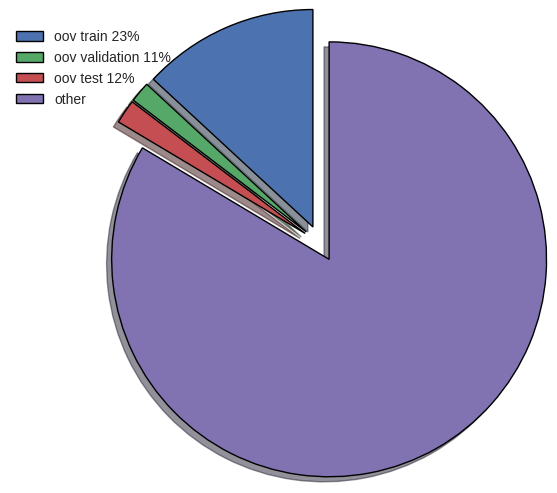

time: 124 ms (started: 2021-12-27 19:15:09 +00:00)


In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(6, 6), dpi=100)
explode_=(0.1, 0.1, 0.1, 0.1)
total=len(word_to_index_train)+len(word_to_index_val)+len(word_to_index_test)
y=np.array([len(oov1), len(oov2), len(oov3), total])
mylabels=['oov train {}%'.format(round(percentage_oov1, 2)), 'oov validation {}%'.format(round(percentage_oov2, 2)), 'oov test {}%'.format(round(percentage_oov3, 2)), 'other' ]
patches, texts=plt.pie(y, startangle=90,radius=1.2, wedgeprops={'edgecolor': 'black', 'linewidth':1}, explode=explode_, shadow=True)
plt.legend(patches, mylabels, loc='upper left', bbox_to_anchor=(-0.2, 1.),
           fontsize=10)
plt.show()

###Base class

In [ ]:
class BaseModel(tf.keras.Model):
    def __init__(self, batch_size, sequence, embedding_matrix,sentence_embedder, embedding_merger, train_word_emb = True,**kwargs):
        super(BaseModel, self).__init__(**kwargs)

        word_voc = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]

        self.trainable = train_word_emb

        self.input_layer_claim = Input(batch_input_shape=(batch_size, sequence),name="claim_input")
        self.input_layer_evidence = Input(batch_input_shape=(batch_size, sequence),name="evidence_input")        
        self.word_embedding = Embedding(word_voc, embedding_dim,weights=[embedding_matrix], trainable=self.trainable,mask_zero=True, name="word_embedding")
        self.sentence_embedder = sentence_embedder
        self.embedding_merger = embedding_merger
        self.classifier = Dense(2, activation="softmax", name="classifier")


    def call(self, claim, evidence):
        claim_word_embedding = self.word_embedding(claim)
        evidence_word_embedding = self.word_embedding(evidence)
        
        claim_sentence_embedding = self.sentence_embedder(claim_word_embedding)
        evidence_sentence_embedding = self.sentence_embedder(evidence_word_embedding)
        merged_embedding = self.embedding_merger(claim_sentence_embedding,evidence_sentence_embedding)
                                            
        output = self.classifier(merged_embedding)
        return output

    def loss(self, y, predictions):
        sce = tf.keras.losses.sparse_categorical_crossentropy(y, predictions, from_logits=False)
        return tf.reduce_mean(sce)

    def metrics(self, y, predictions, loss_obj, acc_obj, f1_obj,precision_obj,recall_obj):
        # loss
        current_loss = self.loss(y, predictions)
        loss_obj.update_state(current_loss)

        pred_np = np.argmax(predictions, axis=-1)

        # accuracy
        acc_obj.update_state(y, pred_np)

        # f1 macro
        y_np = y.numpy().astype(np.int32)
        f1 = f1_score(y_np.flatten(), pred_np.flatten(), average='macro', zero_division=0, labels=[0,1])
        f1_obj.update_state(f1)

        #Precision
        precision = precision_score(y_np.flatten(), pred_np.flatten(), average='macro', zero_division=0, labels=[0,1])
        precision_obj.update_state(precision)

        #Recall
        recall = recall_score(y_np.flatten(), pred_np.flatten(), average='macro', zero_division=0, labels=[0,1])
        recall_obj.update_state(recall)


    def weights(self, other):
        for layer, other_layer in zip(self.layers, other.layers):
            if layer.name == "word_embedding":
                from_weights = other_layer.get_weights()[0];
                new_weights = layer.get_weights()[0][from_weights.shape[0]:]
                layer.set_weights([np.vstack((from_weights, new_weights))])
            else:
                layer.set_weights(other_layer.get_weights())

    def summary(self):
        model = Model(inputs=[self.input_layer_claim, self.input_layer_evidence],outputs=self.call(self.input_layer_claim, self.input_layer_evidence))
        model.summary()

print("********************Sentence Embeddings*********************************")
class BOVEmbeddeing(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BOVEmbeddeing, self).__init__(**kwargs)

    def call(self, x): 
        return tf.reduce_mean(x, axis=1)

class MLPEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, **kwargs):
        super(MLPEmbedding, self).__init__(**kwargs)
        self.flatten = Flatten()
        self.d1 = Dense(embedding_dim)

    def call(self, x):
        flattened = self.flatten(x)
        return self.d1(flattened)

class RNNEmbedding(tf.keras.layers.Layer):
    def __init__(self, latent_dim, average_all_outputs, **kwargs):
        super(RNNEmbedding, self).__init__(**kwargs)
        self.average_all_outputs = average_all_outputs
        self.lstm = Bidirectional(LSTM(latent_dim, return_state=False, return_sequences=self.average_all_outputs))
        
    def call(self, x): 
        if self.average_all_outputs:
            return tf.reduce_mean(self.lstm(x), axis=1)
        else:
            return self.lstm(x)

print("********************Embedding Mergers*********************************")
class Merge(tf.keras.layers.Layer):
    def __init__(self, cosine, **kwargs):
        super(Merge, self).__init__(**kwargs)
        self.cosine = cosine
        self.dot = tf.keras.layers.Dot((1, 1))

    def compute(self, a, b):
        pass

    def call(self, a, b):
        if not self.cosine:
            return self.compute(a, b)
        cs = self.dot([a, b])/(tf.norm(a)*tf.norm(b)+1e-9)
        computed = self.compute(a, b)
        return concatenate([computed, cs])

class Concatenation(Merge):
    def __init__(self, cosine, **kwargs):
        super(Concatenation, self).__init__(cosine, **kwargs)

    def compute(self, a, b): 
        return concatenate([a, b])

class Sum(Merge):
    def __init__(self, cosine, **kwargs):
        super(Sum, self).__init__(cosine, **kwargs)
        self.add_layer = Add()

    def compute(self, a, b): 
        return self.add_layer([a, b])

class Mean(Merge):
    def __init__(self, cosine, **kwargs):
        super(Mean, self).__init__(cosine, **kwargs)
        self.avg_layer = Average()

    def compute(self, a, b):
        return self.avg_layer([a, b])

********************Sentence Embeddings*********************************
********************Embedding Mergers*********************************
time: 249 ms (started: 2021-12-27 19:15:09 +00:00)


###Data Loaders

In [ ]:
class DataLoaders:
    def __init__(self, df, sequence, batch_size):
        self.X = df[['Claim', 'Evidence']]
        self.Y = df['Label'].to_numpy()
        assert self.X.shape[0] == self.Y.shape[0]
        self.sentence = self.X.shape[0]
        self.batch_size = batch_size
        c = []
        e = []

        self.data_list = []
        for i in range(self.sentence):
            claim = np.zeros((sequence))
            evidence = np.zeros((sequence))
            label = self.Y[i]
            l0 = min(len(self.X.iloc[i][0]), sequence)
            l1 = min(len(self.X.iloc[i][1]), sequence)
            c[:l0] = self.X.iloc[i][0][:l0]
            e[:l1] = self.X.iloc[i][1][:l1]
            self.data_list.append((claim, evidence, label))
        self.shuffle()


    def shuffle(self):
        self.current = 0
        random.shuffle(self.data_list)

        num_batches = math.ceil(self.sentence/self.batch_size)
        self.batches_c = []
        self.batches_e = []
        self.batches_y = []
        for i in range(num_batches):
            batchc = []
            batche = []
            batchy = []
            for j in range(self.batch_size):
                if i*self.batch_size+j >= self.sentence:
                    break
                batchc.append(self.data_list[i*self.batch_size+j][0])
                batche.append(self.data_list[i*self.batch_size+j][1])
                batchy.append(self.data_list[i*self.batch_size+j][2])
            self.batches_c.append(np.array(batchc))
            self.batches_e.append(np.array(batche))
            self.batches_y.append(np.array(batchy))

    def __iter__(self):
        return self

    def __next__(self):
        if self.current >= len(self.batches_c):
            raise StopIteration
        claim = self.batches_c[self.current]
        evidence = self.batches_e[self.current]
        y = self.batches_y[self.current]
        claim = tf.cast(claim, tf.float32)
        evidence = tf.cast(evidence, tf.float32)
        y = tf.cast(y, tf.float32)
        self.current += 1
        return claim, evidence, y

time: 56.6 ms (started: 2021-12-27 19:15:09 +00:00)


###Hyperparameter

In [ ]:
sequence = 216
batch_size = 128
max_epochs = 100
learning_rate = 0.01
RNN_latent_dim = 64

time: 2.26 ms (started: 2021-12-27 19:15:09 +00:00)


In [ ]:
train_data = DataLoaders(df_train, sequence, batch_size)
val_data = DataLoaders(df_val, sequence, batch_size)

time: 43.1 s (started: 2021-12-27 19:15:09 +00:00)


In [ ]:
RNNlast = RNNEmbedding(latent_dim=RNN_latent_dim, average_all_outputs=False, name="RNNlast")
RNNavg = RNNEmbedding(latent_dim=RNN_latent_dim, average_all_outputs=True, name="RNNavg")
MLP = MLPEmbedding(embedding_dim=100, name="MLP")
BOV = BOVEmbeddeing(name="BOV")

concat_merge = Concatenation(cosine=False, name="Concatenation")
concat_merge_cosine = Concatenation(cosine=True, name="concat_merge_cosine")

sum_merge = Sum(cosine=False, name="Sum")
sum_merge_cosine = Sum(cosine=True, name="sum_merge_cosine")

mean_merge = Mean(cosine=False, name="Mean")
mean_merge_cosine = Mean(cosine=True, name="mean_merge_cosine")

time: 211 ms (started: 2021-12-27 19:15:53 +00:00)


In [ ]:
def train_step(optimizer, model, claim, evidence, y):
    with tf.GradientTape() as tape:
        predictions = model(claim, evidence)
        loss = model.loss(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return predictions

def val_step(model, claim, evidence):
    predictions = model(claim,evidence)
    return predictions

time: 16.4 ms (started: 2021-12-27 19:16:59 +00:00)


###Testing all the possible combinations

In [ ]:
sentences_emb_list=[RNNlast, RNNavg, BOV, MLP]
embedding_mergers_list=[sum_merge,concat_merge, mean_merge,concat_merge_cosine,sum_merge_cosine,mean_merge_cosine]

time: 12.2 ms (started: 2021-12-27 22:35:09 +00:00)


In [ ]:
# sentences_emb_list=[RNNlast]
# embedding_mergers_list=[concat_merge]

time: 1.4 ms (started: 2021-12-27 19:17:40 +00:00)


In [ ]:
for i in sentences_emb_list:
    for j in embedding_mergers_list:
      model_name = f"{i.name}    {j.name}"
      print("---------------------------------------",model_name,"---------------------------------------------")
      model = BaseModel(batch_size, sequence, embedding_matrix_v2, i, j, name=model_name)
      val_model = BaseModel(batch_size, sequence, embedding_matrix_v3,i, j, name=model_name)
      save_model = BaseModel(batch_size, sequence, embedding_matrix_v4,i, j, name=model_name)

      train_data.shuffle()
      claim, evidence, _ = train_data.__next__()
      val_model(claim, evidence)
      save_model(claim, evidence)

      train_loss_obj = tf.keras.metrics.Mean(name='train_loss')
      train_f1_obj = tf.keras.metrics.Mean(name='train_f1')
      train_acc_obj = tf.keras.metrics.Accuracy(name='train_accuracy')
      train_precision_obj = tf.keras.metrics.Mean(name='train_precision')
      train_recall_obj = tf.keras.metrics.Mean(name='train_recall')

      val_loss_obj = tf.keras.metrics.Mean(name='val_loss')
      val_f1_obj = tf.keras.metrics.Mean(name='val_f1')
      val_acc_obj = tf.keras.metrics.Accuracy(name='val_accuracy')
      val_precision_obj = tf.keras.metrics.Mean(name='val_precision')
      val_recall_obj = tf.keras.metrics.Mean(name='val_recall')

      # optimizer
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

      # train loop
      max_val_acc = -1
      improving = 0
      max_iter = 1

      for epoch in range(max_epochs):
          train_loss_obj.reset_states()
          train_f1_obj.reset_states()
          train_acc_obj.reset_states()
          train_precision_obj.reset_states()
          train_recall_obj.reset_states()

          train_data.shuffle()
          for claim, evidence, y in train_data:
              
              predictions = train_step(optimizer, model, claim, evidence, y)
              model.metrics(y, predictions, train_loss_obj, train_acc_obj, train_f1_obj,train_precision_obj,train_recall_obj)
          print("-----------------------------------------Training-----------------------------------------------")
          print("{}.  \t  loss: {}  \t accuracy: {} \t f1-macro: {} \t Precision: {} \t Recall: {}".format(epoch, round(train_loss_obj.result(),3),round(train_acc_obj.result(),3),round(train_f1_obj.result(),3),round(train_precision_obj.result(),3),round(train_recall_obj.result(),3)))

          # validation
          if True:
              val_loss_obj.reset_states()
              val_acc_obj.reset_states()
              val_f1_obj.reset_states()
              val_precision_obj.reset_states()
              val_recall_obj.reset_states()
              val_model.weights(model)
              val_data.shuffle()
              for claim, evidence, y in val_data:
                  predictions = val_step(val_model, claim, evidence)
                  val_model.metrics(y, predictions, val_loss_obj, val_acc_obj, val_f1_obj,val_precision_obj,val_recall_obj)
              print("-----------------------------------------Validation-----------------------------------------------")
              print("{}.     \t   loss: {}  \t  accuracy: {} \t  f1-macro: {} \t Precision: {} \t Recall: {}".format(epoch,round(val_loss_obj.result(),3),round(val_acc_obj.result(),3),round(val_f1_obj.result(),3),round(val_precision_obj.result(),3),round(val_recall_obj.result(),3)))

              # early stopping
              if val_acc_obj.result() > max_val_acc:
                  save_model.weights(val_model)
                  max_val_acc = val_acc_obj.result()
                  improving = 0
              else:
                  improving += 1
                  if improving >= max_iter:
                      break

###Evaluation on Test Set

In [ ]:
from sklearn.metrics import confusion_matrix
def evaluate_on_test_Set(model):
  test_loss_obj = tf.keras.metrics.Mean(name='test_loss')
  test_f1_obj = tf.keras.metrics.Mean(name='test_f1')
  test_acc_obj = tf.keras.metrics.Accuracy(name='test_accuracy')
  test_precision_obj = tf.keras.metrics.Mean(name='test_precision')
  test_recall_obj = tf.keras.metrics.Mean(name='test_recall')

  test_data = DataLoaders(df_test, sequence, batch_size)
  test_data.shuffle()
  for claim, evidence, y in test_data:
      predictions = val_step(model, claim, evidence)
      model.metrics(y, predictions, test_loss_obj, test_acc_obj, test_f1_obj,test_precision_obj,test_recall_obj)
  test_log = "\n{}  \tloss: {}  \t accuracy: {} \t f1-macro: {} \t Precision: {} \t Recall: {}\n".format(epoch,test_loss_obj.result(),test_acc_obj.result(),test_f1_obj.result(),test_precision_obj.result(),test_recall_obj.result())
  print(test_log)

In [ ]:
evaluate_on_test_Set(save_model)